## Read Me

- change chunks with "(customize)"  upon design
- following instructions in the readme.md file, download and unzip data folders in the correct directory
- task of this demo notebook:
    + clip piecewise text to the paired time series
    + evalute the zero-shot prediction performance on binary classification of "NICU death in 7 days".


In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
from config import *
from encoder import *
from data import *
from clip import *
from clip3d import *
from eval import *
from augmentor import *
from describer import *
from masker import *
print("using device: ", device)
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# import pkg_resources
# print(pkg_resources.get_distribution('python-calamine').version)



Random seed set to 333
using device:  cpu


In [7]:
# ---- (customize) update configs ----
overwrite = True
model_name = 'testtest'
text_config['cl']['die7d'] = True # udpate text_config here if needed
text_config['split'] = True
text_config['demo']['gre'] = True
text_config['demo']['apgar_mage'] = True
model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    model_name = model_name,
    ts_aug = True,
    ts_subseq = True,
    ts_augsub = False,
    balance = True,
    block_target = True,
    batch_size = 2048, # larger batch 
    patience = 30,
    num_saves = 20,
    num_epochs = 1,
    text_config = text_config,
    text_col_ls = ['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother']
)
config_dict = get_config_dict()



In [4]:
# ---- ready original dataframes ----
# Train Data
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# Test Data
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org[config_dict['y_col']], random_state=config_dict['random_state']) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.2s
[Parallel(n_jobs=9)]: Done 7433 tasks      | elapsed:    5.5s
[Parallel(n_jobs=9)]: Done 63776 tasks      | elapsed:   12.9s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   13.0s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams. This infant is Female Black non-Hispanic. The Apgar5 scores 6. Mother is 21 years old.    Moderate variability.  Very low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.2s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    8.1s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    8.1s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams. This infant is Male non-Black non-Hispanic. The Apgar5 scores 9. Mother is 26 years old.    High variability.  Low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']


In [5]:
# ---- downsample negative class(es) ----
df_train = downsample_neg_levels(df_train, config_dict, config_dict['random_state'])
df_test = downsample_neg_levels(df_test, config_dict, config_dict['random_state'])

# ---- augment + balance train data----
# target_event_rate = len(df_test[df_test[config_dict['y_col']]==config_dict['y_levels'][0]])/len(df_test)
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    config_dict['y_levels'], 
                                    config_dict['y_col'], 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth')
    df_test['augid'] = 0

# ---- created masked subsequences of each time series ----
if config_dict['ts_subseq']:
    df_train = subseq_raw_df(df_train,config_dict)
    df_test = subseq_raw_df(df_test,config_dict)
    # Fill nan with -1 
    df_train.loc[:, '1':'300'] = df_train.loc[:, '1':'300'].fillna(-1)
    df_test.loc[:, '1':'300'] = df_test.loc[:, '1':'300'].fillna(-1)


# ---- block or not ----
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    if 'subid' in df_train.columns:
        if config_dict['ts_augsub']:
            # = get a subsequence then augment it multiple times
            df_train['label'] = df_train['rowid'].astype(int)*100 + df_train['subid'].astype(int)
            df_test['label'] = df_test['rowid'].astype(int)*100 + df_test['subid'].astype(int)
        else:
            # get unqiue subsequences for each augmentation
            df_train['label'] = df_train['rowid'].astype(int)*10000 + df_train['augid'].astype(int)*100 + df_train['subid'].astype(int)
            df_test['label'] = df_test['rowid'].astype(int)*10000 + df_test['augid'].astype(int)*100 + df_test['subid'].astype(int)

    else:
        df_train['label'] = df_train['rowid'].astype(int)
        df_test['label'] = df_test['rowid'].astype(int)


After downsampling:
cl_event
This infant will survive.           1000
This infant will die in 7 days.      384
Name: count, dtype: int64
After downsampling:
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64
Original class distribution:
Class This infant will die in 7 days. : 384
Class This infant will survive. : 1000

Target size per class: 1000
Total cores available: 12
Using 9 cores for parallel processing


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.


Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333


[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    2.1s
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by

Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333


[Parallel(n_jobs=9)]: Done 384 out of 384 | elapsed:    9.4s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 751 out of 768 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=9)]: Done 768 out of 768 | elapsed:    1.0s finished


This infant will die in 7 days.  This infant has gestational age 24 weeks. Birth weight is 400 grams. This infant is Male non-Black non-Hispanic. The Apgar5 scores 2. Mother is 29 years old.    Moderate variability.  Low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']
Augmented 1536 rows

Final class distribution:
Class This infant will die in 7 days. : 1000
Class This infant will survive. : 1000
Using 9 cores for parallel processing


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 1904 tasks      | elapsed:    0.8s


Random seed set to 333
This infant will survive.  This infant has gestational age 26 weeks. Birth weight is 380 grams. This infant is Female Black non-Hispanic. The Apgar5 scores 7. Mother is 26 years old.    Moderate variability.  Very low amount of consecutive increases. 


[Parallel(n_jobs=9)]: Done 2000 out of 2000 | elapsed:    1.5s finished
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/script/CLIP/data.py:579: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['text'][0])



Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']
After Subsequence Extraction:
cl_event
This infant will survive.           2000
This infant will die in 7 days.     2000
Name: count, dtype: int64
Using 9 cores for parallel processing


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s


This infant will die in 7 days.  This infant has gestational age 31 weeks. Birth weight is 1830 grams. This infant is Female non-Black non-Hispanic. The Apgar5 scores 6. Mother is 23 years old.    Moderate variability.  Moderate amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']
After Subsequence Extraction:
cl_event
This infant will survive.           2000
This infant will die in 7 days.      482
Name: count, dtype: int64


[Parallel(n_jobs=9)]: Done 1208 tasks      | elapsed:    0.4s
[Parallel(n_jobs=9)]: Done 1241 out of 1241 | elapsed:    0.4s finished
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/script/CLIP/data.py:579: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['text'][0])


In [6]:
# ---- ready eval inputs ----
n_levels = len(config_dict['y_levels'])
clip_type = "3d" if config_dict['3d'] else "2d"

for i in range(n_levels):
    df_train[f'true{i+1}'] = df_train[config_dict['y_col']].apply(lambda x: 1 if x == config_dict['y_levels'][i] else 0)
    df_train[f'text{i+1}'] = config_dict['y_pred_levels'][i]
for i in range(n_levels):
    df_test[f'true{i+1}'] = df_test[config_dict['y_col']].apply(lambda x: 1 if x == config_dict['y_levels'][i] else 0)
    df_test[f'text{i+1}'] = config_dict['y_pred_levels'][i]

evalinputs_train = EvalInputs(df_train, 
                            config_dict['ts_encoder_name'],
                            config_dict['text_encoder_name'], 
                            config_dict['ts_normalize'], 
                            config_dict['ts_encode'],
                            y_true_cols = [f'true{i+1}' for i in range(n_levels)],
                            y_pred_cols = [f'text{i+1}' for i in range(n_levels)],
                            y_pred_cols_ls = config_dict['y_pred_cols_ls'],
                            clip_type=clip_type)
evalinputs_test = EvalInputs(df_test, 
                            config_dict['ts_encoder_name'],
                            config_dict['text_encoder_name'], 
                            config_dict['ts_normalize'], 
                            config_dict['ts_encode'],
                            y_true_cols = [f'true{i+1}' for i in range(n_levels)],
                            y_pred_cols = [f'text{i+1}' for i in range(n_levels)],
                            y_pred_cols_ls = config_dict['y_pred_cols_ls'],
                            clip_type=clip_type)


print(df_train[config_dict['y_col']].value_counts())
print(df_test[config_dict['y_col']].value_counts())

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will survive.           2000
This infant will die in 7 days.     2000
Name: count, dtype: int64
cl_event
This infant will survive.           2000
This infant will die in 7 days.      482
Name: count, dtype: int64


# Main Usage

In [8]:

output_dir = './results/'+model_name
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'


if overwrite:
    # ------------------------- ready dataloaders ------------------------- 
    if config_dict['3d']:
        ts_f_train, tx_f_train_ls, labels_train = get_features3d(df_train,
                                                                config_dict['ts_encoder_name'], 
                                                                config_dict['text_encoder_name'], 
                                                                config_dict['ts_normalize'],
                                                                config_dict['ts_encode'],
                                                                text_col_ls = config_dict['text_col_ls'])
        train_dataloader = CLIP3DDataset(ts_f_train, tx_f_train_ls, labels_train).dataloader(batch_size=config_dict['batch_size'])
        ts_f_test, tx_f_test_ls, labels_test = get_features3d(df_test, 
                                                            config_dict['ts_encoder_name'], 
                                                            config_dict['text_encoder_name'], 
                                                            config_dict['ts_normalize'],
                                                            config_dict['ts_encode'],
                                                            text_col_ls = config_dict['text_col_ls'])
        test_dataloader = CLIP3DDataset(ts_f_test, tx_f_test_ls, labels_test).dataloader(batch_size=config_dict['batch_size'])
    else: 
        ts_f_train, tx_f_train, labels_train = get_features(df_train,
                                                            config_dict['ts_encoder_name'], 
                                                            config_dict['text_encoder_name'], 
                                                            config_dict['ts_normalize'],
                                                            config_dict['ts_encode'])
        train_dataloader = CLIPDataset(ts_f_train, tx_f_train, labels_train).dataloader(batch_size=config_dict['batch_size'])
        ts_f_test, tx_f_test, labels_test = get_features(df_test, 
                                                        config_dict['ts_encoder_name'], 
                                                        config_dict['text_encoder_name'], 
                                                        config_dict['ts_normalize'],
                                                        config_dict['ts_encode'])
        test_dataloader = CLIPDataset(ts_f_test, tx_f_test, labels_test).dataloader(batch_size=config_dict['batch_size'])
    
    # ------------------------- ready model (customize) -------------------------
    # get the dimension out
    if config_dict['3d']:
        ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.loc[:1,:], 
                                                        config_dict['ts_encoder_name'], 
                                                        config_dict['text_encoder_name'], 
                                                        config_dict['ts_normalize'],
                                                        config_dict['ts_encode'],
                                                        text_col_ls = config_dict['text_col_ls'])
    else:
        ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.loc[:1,:], 
                                                        config_dict['ts_encoder_name'], 
                                                        config_dict['text_encoder_name'], 
                                                        config_dict['ts_normalize'],
                                                        config_dict['ts_encode'])
    # lstm_encoder = LSTMEncoder(ts_dim=300, output_dim=128, num_layers=4, hidden_dim=256, dropout=0.1)
    lstm_encoder = MultiLSTMEncoder(
        ts_dim=ts_f_dim.shape[1], 
        output_dim=128,
        hidden_dims=[256, 256, 256, 128, 128, 128],  # LSTMs with different sizes
        num_layers=2,
        mask=-1
    )
    if config_dict['3d']:
        model = CLIP3DModel(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=lstm_encoder
                )
    else:
        model = CLIPModel(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=lstm_encoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    optimizer = torch.optim.AdamW(model.parameters(), lr=config_dict['init_lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',           # Reduce LR when metric stops decreasing
        factor=0.9,          # Multiply LR by this factor
        patience=config_dict['patience'],          # Number of epochs to wait before reducing LR
        min_lr=1e-20         # Don't reduce LR below this value
    )
    train_eval_metrics_list = []
    test_eval_metrics_list = []
    train_losses = []
    test_losses = []

    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    torch.save(config_dict, config_path)
    overwrite = False # reset overwrite to False
    

Layer (type:depth-idx)                                                 Param #
CLIP3DModel                                                            1
├─MultiLSTMEncoder: 1-1                                                --
│    └─ModuleList: 2-1                                                 --
│    │    └─LSTM: 3-1                                                  1,097,728
│    │    └─LSTM: 3-2                                                  1,097,728
│    │    └─LSTM: 3-3                                                  1,097,728
│    │    └─LSTM: 3-4                                                  352,256
│    │    └─LSTM: 3-5                                                  352,256
│    │    └─LSTM: 3-6                                                  352,256
│    └─Sequential: 2-2                                                 --
│    │    └─Linear: 3-7                                                664,128
│    │    └─BatchNorm1d: 3-8                                       

In [ ]:
# allow conditue training if set overwrite to True here.
if overwrite or not os.path.exists(model_path):

    for i in range(2000): 
        print(i)
        train_losses_tmp, test_losses_tmp = train_clip(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                config_dict['num_epochs'], 
                                                device,
                                                config_dict['loss_type'])
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        train_eval_metrics = eval_clip3d(model, evalinputs_train)
        test_eval_metrics = eval_clip3d(model, evalinputs_test)
        train_eval_metrics_list.append(train_eval_metrics)
        test_eval_metrics_list.append(test_eval_metrics)
        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_evals': train_eval_metrics_list,
            'test_evals': test_eval_metrics_list }, eval_path)
        # if i % 10 == 0: # every 10 saves, evaluate the model
        eval_dict = torch.load(eval_path)
        eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)
else:
    config_dict = torch.load(config_path)
    model = config_dict['model_init']
    model.load_state_dict(torch.load(model_path))
    model.eval()
    eval_dict = torch.load(eval_path)
    eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot_confusion_matrices=False)

0
Epoch [1/1]
	Training Loss: 20.250200
	Testing Loss: 7.689697
	Learning Rate: 0.000100000
----------------------------------------------------------------------
Metric     |  Training  |  Testing
----------------------------------------------------------------------
F1        |   0.139   |   0.105
Precision |   0.564   |   0.202
Recall    |   0.080   |   0.071
AUROC     |   0.506   |   0.500
AUPRC     |   0.508   |   0.194
----------------------------------------------------------------------
1
Epoch [1/1]
	Training Loss: 18.610978
	Testing Loss: 7.661354
	Learning Rate: 0.000100000
----------------------------------------------------------------------
Metric     |  Training  |  Testing
----------------------------------------------------------------------
F1        |   0.672   |   0.328
Precision |   0.508   |   0.197
Recall    |   0.992   |   0.990
AUROC     |   0.510   |   0.490
AUPRC     |   0.509   |   0.194
----------------------------------------------------------------------


# dignostic plots

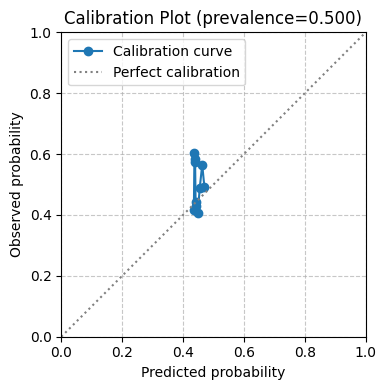

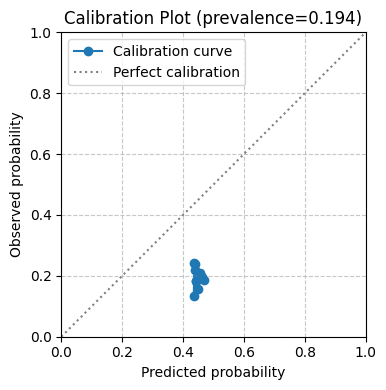

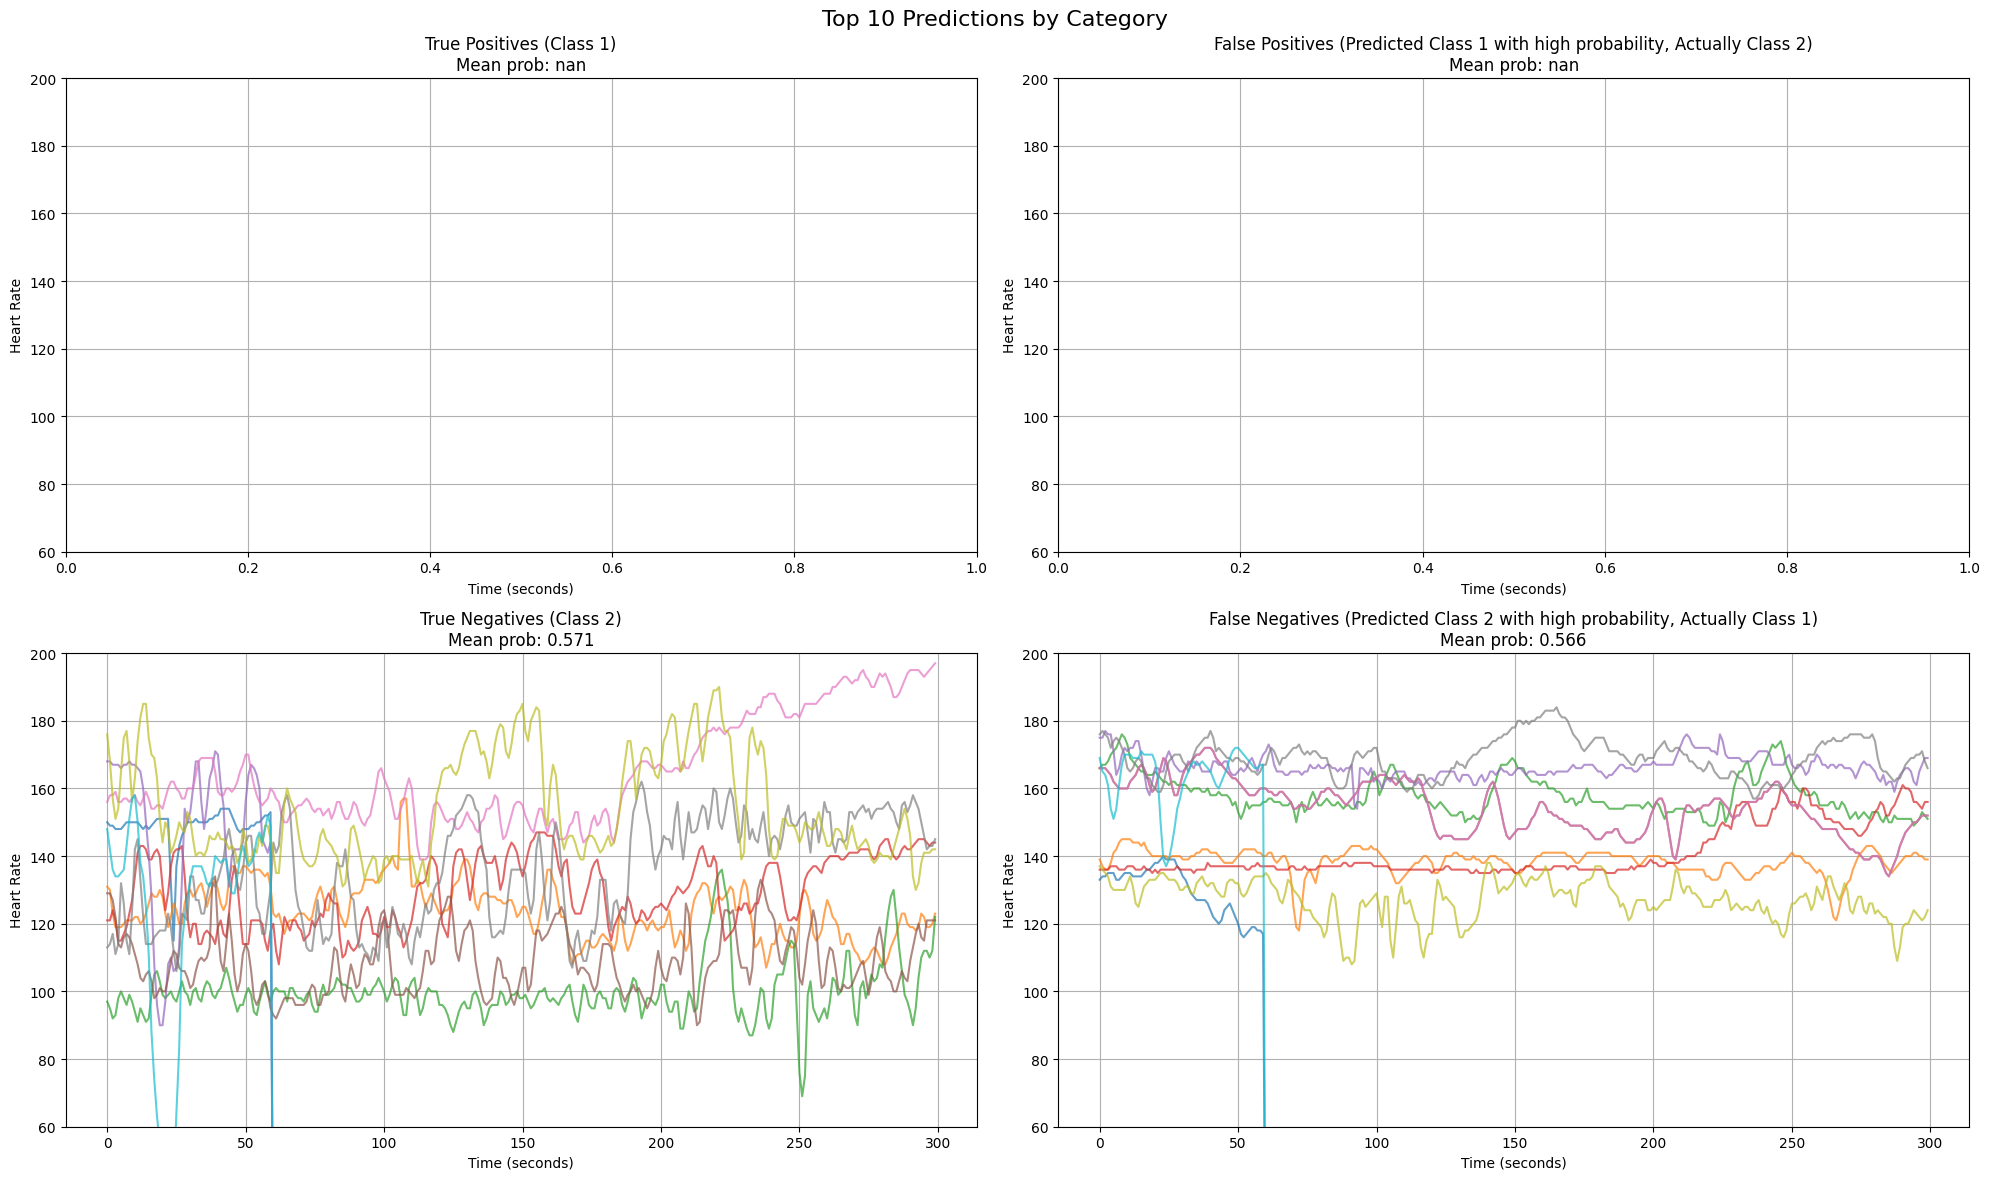

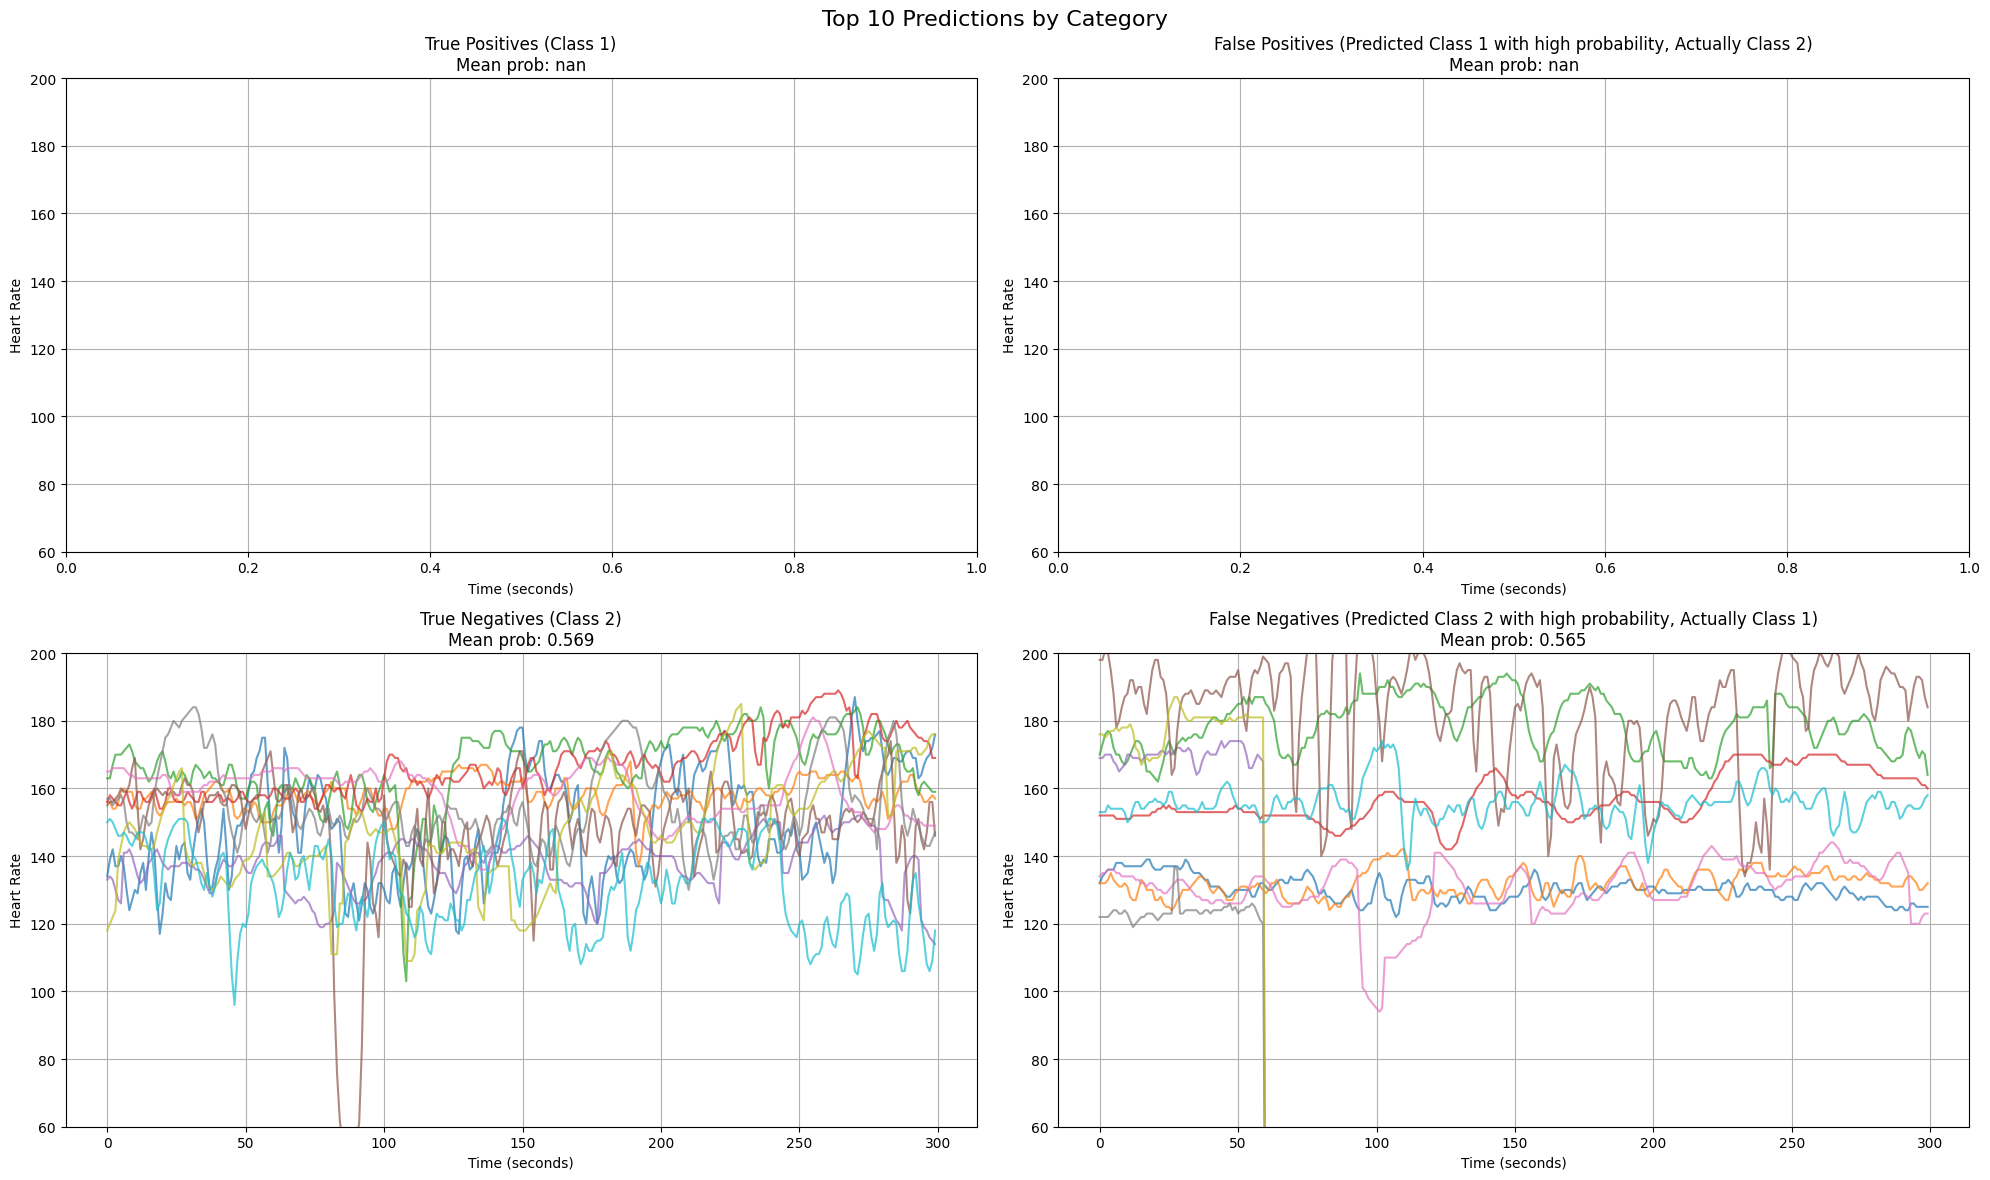

In [13]:
_, y_prob_test = eval_clip3d(model, evalinputs_test, return_probs=True)
_, y_prob_train = eval_clip3d(model, evalinputs_train, return_probs=True)
y_prob_test = pd.DataFrame(y_prob_test.cpu().numpy())
y_prob_train = pd.DataFrame(y_prob_train.cpu().numpy())

y_true_test = df_test[['true1','true2']]
y_true_train = df_train[['true1','true2']]

y_prob_test_recal = recalibrate_probabilities(y_true_test, y_prob_test, method='platt')
y_prob_train_recal = recalibrate_probabilities(y_true_train, y_prob_train, method='platt')

df_train_cali = diag_cali_plot(y_true_train, y_prob_train)
df_test_cali = diag_cali_plot(y_true_test, y_prob_test )
# df_train_cali = diag_cali_plot(y_true_train, y_prob_train_recal, n_bins=8)
# df_test_cali = diag_cali_plot(y_true_test, y_prob_test_recal, n_bins=8)
ts_train_idx = diag_plot_top_k_predictions(y_true_train, y_prob_train, df_train, K=10)
ts_test_idx = diag_plot_top_k_predictions(y_true_test, y_prob_test, df_test, K=10)

ts_train_idx = diag_plot_top_k_predictions(y_true_train, y_prob_train, df_train, K=50, plot=False)
ts_test_idx = diag_plot_top_k_predictions(y_true_test, y_prob_test, df_test, K=50, plot=False)
combined_idx = np.concatenate([ts_train_idx['true_pos_idx'], ts_train_idx['true_neg_idx']]).tolist()
df_train_shapelet = df_train.loc[combined_idx, :]
combined_idx = np.concatenate([ts_test_idx['true_pos_idx'], ts_test_idx['true_neg_idx']]).tolist()
df_test_shapelet = df_test.loc[combined_idx, :]

# df_train_shapelet.to_csv('./results/train_shapelet.csv')
# df_test_shapelet.to_csv('./results/test_shapelet.csv')